<a href="https://colab.research.google.com/github/EduardoAVS/LSTM-StockPrediction/blob/main/model_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance pytrends numpy pandas scikit-learn tensorflow


# 1) Coleta dos dados



a) Dados yfinance:

In [ ]:
import yfinance as yf
import pandas as pd

# Definir o ticker e o período
ticker = 'ITUB4.SA'
periodo = '10y'

# Baixar os dados
dados_acoes = yf.download(ticker, period=periodo)
dados_acoes.columns = dados_acoes.columns.get_level_values(0) # Remove o nível Ticker adicionado automaticamente pelo yfinance


[*********************100%***********************]  1 of 1 completed


In [ ]:
dados_acoes

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-11-07 00:00:00+00:00,12.765445,19.917355,19.961432,19.349861,19.548208,18694137
2014-11-10 00:00:00+00:00,12.730133,19.862259,20.297520,19.779613,20.159779,13523746
2014-11-11 00:00:00+00:00,12.723076,19.851238,20.110191,19.559229,19.663912,11512182
2014-11-12 00:00:00+00:00,12.818420,20.000000,20.451790,19.592285,19.691460,17742895
2014-11-13 00:00:00+00:00,12.405258,19.355371,20.258953,19.338842,20.203856,15550738
...,...,...,...,...,...,...
2024-11-01 00:00:00+00:00,34.810001,34.810001,35.299999,34.790001,35.000000,22751600
2024-11-04 00:00:00+00:00,35.279999,35.279999,35.540001,34.889999,35.130001,20499900
2024-11-05 00:00:00+00:00,36.340000,36.340000,36.650002,35.599998,35.700001,52524800


b) Dados do Google Trends:

In [ ]:
from pytrends.request import TrendReq

# Inicializar o pytrends
pytrends = TrendReq(hl='pt-BR', tz=0)

# Definir o termo de busca e o período
termo_busca = 'Itaú Unibanco'

pytrends.build_payload([termo_busca], cat=0, timeframe='2014-11-07 2024-11-07', geo='BR', gprop='')
dados_trends1 = pytrends.interest_over_time()

pytrends.build_payload([termo_busca], cat=0, timeframe='2019-11-08 2024-11-07', geo='BR', gprop='')
dados_trends2 = pytrends.interest_over_time()


/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [ ]:

# Remove a coluna 'isPartial'
dados_trends1 = dados_trends1.drop(columns=['isPartial'], errors='ignore')
dados_trends2 = dados_trends2.drop(columns=['isPartial'], errors='ignore')

# Combinar os dois DataFrames
dados_trends = pd.concat([dados_trends1, dados_trends2])

dados_trends = dados_trends.rename(columns={'Itaú Unibanco': 'Trends'})

dados_trends

,Trends
date,
2014-11-01,43
2014-12-01,38
2015-01-01,37
2015-02-01,42
2015-03-01,42
...,...
2024-10-06,36
2024-10-13,38
2024-10-20,39


In [ ]:
print(dados_acoes.dtypes)
print("\n",dados_trends.dtypes)

Price
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object

 Trends    int64
dtype: object


# 2) Pré-processamento dos Dados

In [ ]:
# Verificar se há duplicatas no índice
duplicated_dates = dados_trends.index[dados_trends.index.duplicated()]
print("Datas duplicadas:", duplicated_dates)

# Remover duplicatas mantendo apenas a primeira ocorrência
dados_trends = dados_trends[~dados_trends.index.duplicated(keep='first')]


Datas duplicadas: DatetimeIndex(['2019-12-01', '2020-03-01', '2020-11-01', '2021-08-01',
               '2022-05-01', '2023-01-01', '2023-10-01', '2024-09-01'],
              dtype='datetime64[ns]', name='date', freq=None)


a) Combinar Dados:

In [ ]:
# Converter o índice de dados_acoes para tz-naive (remover fuso horário) para permitir a inner join
dados_acoes.index = dados_acoes.index.tz_localize(None)

dados_trends = dados_trends.sort_index()

# Expandir os dados do Google Trends para valores diários usando forward fill
dados_trends_diarios = dados_trends.reindex(dados_acoes.index, method='ffill')

# Agora você pode realizar o merge com dados diários
dados = pd.merge(dados_acoes, dados_trends_diarios, left_index=True, right_index=True)

# Exibir as primeiras linhas dos dados combinados
dados


,Adj Close,Close,High,Low,Open,Volume,Trends
Date,,,,,,,
2014-11-07,12.765445,19.917355,19.961432,19.349861,19.548208,18694137,43
2014-11-10,12.730133,19.862259,20.297520,19.779613,20.159779,13523746,43
2014-11-11,12.723076,19.851238,20.110191,19.559229,19.663912,11512182,43
2014-11-12,12.818420,20.000000,20.451790,19.592285,19.691460,17742895,43
2014-11-13,12.405258,19.355371,20.258953,19.338842,20.203856,15550738,43
...,...,...,...,...,...,...,...
2024-11-01,34.810001,34.810001,35.299999,34.790001,35.000000,22751600,65
2024-11-04,35.279999,35.279999,35.540001,34.889999,35.130001,20499900,39
2024-11-05,36.340000,36.340000,36.650002,35.599998,35.700001,52524800,39


b) Criação de Variável Alvo:

In [ ]:
# Remover linhas com valores NaN
dados = dados.dropna()


# Exibir as primeiras linhas dos dados processados
print(dados.head())


            Adj Close      Close       High        Low       Open    Volume  \
Date                                                                          
2014-11-07  12.765445  19.917355  19.961432  19.349861  19.548208  18694137   
2014-11-10  12.730133  19.862259  20.297520  19.779613  20.159779  13523746   
2014-11-11  12.723076  19.851238  20.110191  19.559229  19.663912  11512182   
2014-11-12  12.818420  20.000000  20.451790  19.592285  19.691460  17742895   
2014-11-13  12.405258  19.355371  20.258953  19.338842  20.203856  15550738   

            Trends  
Date                
2014-11-07      43  
2014-11-10      43  
2014-11-11      43  
2014-11-12      43  
2014-11-13      43  


# 3) Divisão dos Dados em Treinamento e Teste

# Treinamento e avaliação do modelo

In [ ]:
# Importing required libraries for LSTM model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
dados.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Trends'], dtype='object')

### 3) Preparação dos Dados para o Modelo LSTM

In [ ]:
entrada = dados[['High', 'Low', 'Open', 'Volume', 'Trends']]
fechamento = dados[['Close']]

# Escalar os dados de entrada e o preço de fechamento separadamente
scaler_entrada = MinMaxScaler(feature_range=(0, 1))
atributos_entrada_escalados = scaler_entrada.fit_transform(entrada)

scaler_saida = MinMaxScaler(feature_range=(0, 1))
fechamento_escalado = scaler_saida.fit_transform(fechamento)


In [ ]:
def criar_sequencias(atributos, fechamento, seq_length=60):
    X, y = [], []
    for i in range(len(atributos) - seq_length):
        X.append(atributos[i:i + seq_length])  # 7 atributos para 60 dias
        y.append(fechamento[i + seq_length])   # preço de fechamento no dia seguinte
    return np.array(X), np.array(y)

sequence_length = 60
X, y = criar_sequencias(atributos_entrada_escalados, fechamento_escalado, sequence_length)

# Verifique o formato dos dados de entrada e saída
print(X.shape, y.shape)

# Calcular tamanhos dos conjuntos de treino, validação e teste futuro
train_size = int(len(X) * 0.7)       # 70% para treino
val_size = int(len(X) * 0.3)          # 30% para validação

# Dividir os conjuntos de dados
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Verificar os tamanhos dos conjuntos
print(f"Tamanho de X_train: {X_train.shape}, Tamanho de X_val: {X_test.shape}")
print(f"Tamanho de y_train: {y_train.shape}, Tamanho de y_val: {y_test.shape}")


(2429, 60, 5) (2429, 1)
Tamanho de X_train: (1700, 60, 5), Tamanho de X_val: (728, 60, 5)
Tamanho de y_train: (1700, 1), Tamanho de y_val: (728, 1)


### 4) Construção e Treinamento do Modelo LSTM

In [ ]:

# Construir o modelo LSTM
model = Sequential([
    LSTM(30, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), # Faz o modelo esquecer 30% das informações evitando overfitting
    Dense(5),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, callbacks=[early_stopping])


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0371 - val_loss: 0.0021
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0044 - val_loss: 8.0867e-04
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031 - val_loss: 7.3078e-04
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0034 - val_loss: 7.7158e-04
Epoch 9/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0032 - val_loss: 7.4063e-04
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss

In [ ]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 30)                  │           4,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 5)                   │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,445 (52.52 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,964 (35.02 KB)

### 5) Avaliação do Modelo e Previsões

Train Loss: 0.0010
Test Loss: 0.0007
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


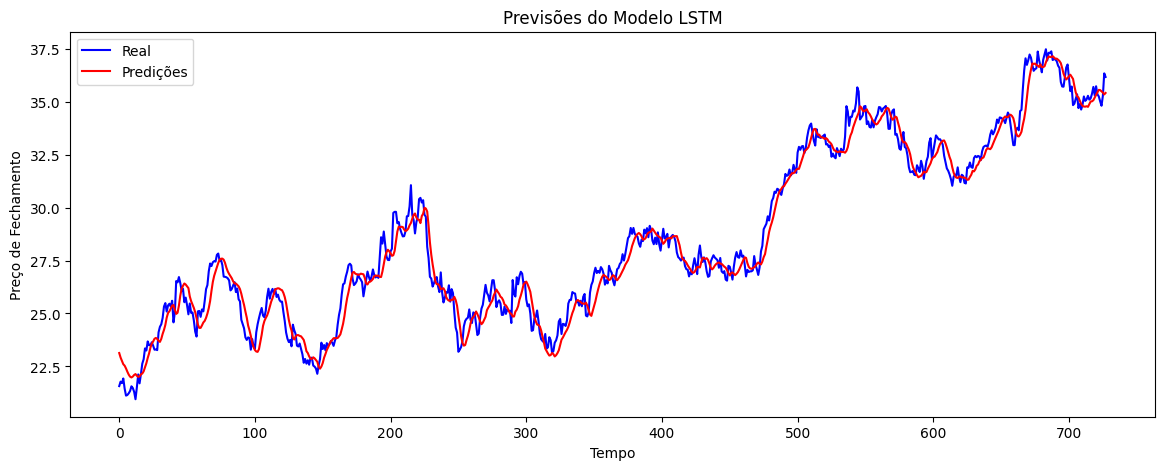

In [ ]:

# Avaliar o modelo nos dados de teste
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Fazer previsões
predictions = model.predict(X_test)

# Reverter a escala das previsões usando scaler_saida
predictions = scaler_saida.inverse_transform(predictions)

# Reverter a escala dos dados reais de y_test para comparação
y_test_inverso = scaler_saida.inverse_transform(y_test.reshape(-1, 1))
# Exibir as primeiras previsões vs valores reais
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test_inverso, color='blue', label='Real')
plt.plot(predictions, color='red', label='Predições')
plt.title('Previsões do Modelo LSTM')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_inverso = scaler_saida.inverse_transform(y_test.reshape(-1, 1))
predicitions = scaler_saida.inverse_transform(predictions.reshape(-1, 1))

# Calculando o Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverso, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculando o Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculando o Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverso, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculando o R-squared (R²)
r2 = r2_score(y_test_inverso, predictions)
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 0.4767468342435458
Root Mean Squared Error (RMSE): 0.6904685613723088
Mean Absolute Error (MAE): 0.5456474272759407
R-squared (R²): 0.9719601971811876


In [ ]:
# Parâmetro de sequência (por exemplo, janela de 60 dias)
sequence_length = 60

# Obter a última sequência dos atributos de entrada para fazer a previsão do próximo fechamento
ultima_sequencia = atributos_entrada_escalados[-sequence_length:]
ultima_sequencia = np.reshape(ultima_sequencia, (1, sequence_length, ultima_sequencia.shape[1]))

# Fazer a previsão do próximo valor
previsao = model.predict(ultima_sequencia)

# Reverter a escala para obter o valor original do fechamento
previsao_dia_seguinte = scaler_saida.inverse_transform(previsao)

# Exibir a previsão
print(f"Previsão para o fechamento de amanhã: {previsao_dia_seguinte[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Previsão para o fechamento de amanhã: 35.6294


In [ ]:
ultima_sequencia

array([[[0.91056598, 0.92838463, 0.94217705, 0.21461892, 0.38202247],
        [0.90162244, 0.93408128, 0.92762017, 0.13858414, 0.37078652],
        [0.90551097, 0.93245377, 0.93247241, 0.0980918 , 0.37078652],
        [0.90628867, 0.93937108, 0.94581627, 0.08796172, 0.37078652],
        [0.88179148, 0.91454985, 0.9049761 , 0.13357138, 0.37078652],
        [0.89345676, 0.91739818, 0.92398094, 0.1353869 , 0.37078652],
        [0.87751417, 0.9129222 , 0.91346757, 0.08961915, 0.3258427 ],
        [0.88023607, 0.91577067, 0.91346757, 0.09111663, 0.3258427 ],
        [0.90978827, 0.91170153, 0.90659357, 0.19842733, 0.3258427 ],
        [0.90628867, 0.94140558, 0.94015514, 0.13830344, 0.3258427 ],
        [0.89034609, 0.91902583, 0.92559841, 0.38368917, 0.3258427 ],
        [0.87984729, 0.91617751, 0.91508503, 0.06328503, 0.69662921],
        [0.89112379, 0.91699134, 0.91185026, 0.0979418 , 0.69662921],
        [0.92223126, 0.94384706, 0.93853783, 0.12641634, 0.69662921],
        [0.91484313,